In [1]:
# Data based on:
# https://doi.org/10.1016/j.ymben.2014.07.004

In [2]:
# Libraries and global parameters
# Dynamic block
import numpy as np
from scipy.integrate import odeint
# Metabolic block
import cobra
import os
from os.path import join
data_dir="."
model=cobra.io.read_sbml_model(join(data_dir, "iMM904.xml"))
# Plotting libraries
import matplotlib.pyplot as plt

In [3]:
# Kinetic block
def kineticBlock(Glu,Eth):
    # Parameters
    vGmax, K_Glu, K_Eth = 22.5, 0.88, 6.74
    f_Eth,f_Gly, f_Cit, f_Lac = .112, .273, .169, .137
    v_Glu=vGmax*Glu/(K_Glu+Glu)*1/(1+Eth/K_Eth)
    LB_Eth = v_Glu*f_Eth
    LB_Gly = v_Glu*f_Gly
    LB_Cit = v_Glu*f_Cit
    LB_Lac = v_Glu*f_Lac
    #LB_ATP_Ex = m_ATP
    return [v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac]

In [4]:
# Metabolic block
def metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac):
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = -v_Glu # set flux of glucose
    solution = model.optimize()
    u = solution.f
    v_Eth = model.reactions.get_by_id("EX_etoh_e").x
    v_Gly = model.reactions.get_by_id("EX_glyc_e").x
    v_Cit = model.reactions.get_by_id("EX_cit_e").x
    v_Lac = model.reactions.get_by_id("EX_lac__D_e").x
    return [u, v_Eth, v_Gly, v_Cit, v_Lac]

In [5]:
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VEth,VGly,VCit,VLac = y # Current values
    F,u, v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params  # unpack parameters
    Glu_F = 300 # Glucose concentration on feed
    MW_Glu,MW_Eth,MW_Gly,MW_Cit,MW_Lac = [0.18,.046,.092,.192,.090]
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_Eth*MW_Eth*(VX), # dVEth/dt
            v_Gly*MW_Gly*(VX), # dVGly/dt
            v_Cit*MW_Cit*(VX), # dVCit/dt
            v_Lac*MW_Lac*(VX)] # dVLac/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    #F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params
    soln = odeint(f,y,time,args=(params,))
    V=soln[-1,0]
    X,Glu,Eth,Gly,Cit,Lac=soln[-1,1:7]/V
    return [V,X,Glu,Eth,Gly,Cit,Lac]

In [6]:
# Miscelaneous functions
# Feed flow 
def F(t):
    V_0 =   0.5
    X_0 =   0.5
    Ysx =   0.469
    ti = 0
    SF  = 300
    A,B,C=[0.07,0.07,0.14]
    u_set=A+B*np.exp(-C*t)
    integral = A*(t-ti) + B/C*(np.exp(-C*ti)-np.exp(-C*t)) 
    F= u_set/(SF*Ysx) * V_0*X_0 * np.exp(integral)
    return F
# Save results along the fermentation path
u_path,V_path,X_path = [],[],[]
Glu_path,Eth_path,Gly_path,Cit_path,Lac_path = [],[],[],[],[]
v_Glu_path=[]
def savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu):
    global u_path,V_path,X_path
    global Glu_path,Eth_path,Gly_path,Cit_path,Lac_path
    global v_Glu_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    Eth_path += [Eth]
    Gly_path += [Gly]
    Cit_path += [Cit]
    Lac_path += [Lac]
    v_Glu_path += [v_Glu]
    

In [15]:
# Initial conditions
Glu=20
Eth,Gly,Cit,Lac=[0,0,0,0]
V,X=[0.5,0.5]

# Running simulation
time=np.linspace(0,22,200)
for i in range(len(time)):
    if i%10==0: print "\t".join( map(str,[time[i:(i+2)], F(time[i]),V, Glu, X, Eth]) )
    # Kinetic block
    v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac = kineticBlock(Glu,Eth)
    # Metabolic block
    u,v_Eth, v_Gly, v_Cit, v_Lac = metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac)
    # Dynamic block
    if i==len(time)-1: continue 
    y = [V,X*V,Glu*V,Eth*V,Gly*V,Cit*V,Lac*V]
    params = [F(time[i]),u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac]
    V,X,Glu,Eth,Gly,Cit,Lac = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu)

[ 0.          0.11055276]	0.000248756218905	0.5	20	0.5	0
[ 1.10552764  1.2160804 ]	0.000268046461863	0.500284592582	17.456425588	0.888639819004	1.13977438588
[ 2.21105528  2.32160804]	0.000287583704659	0.500590610545	13.7870905409	1.45642076685	2.74410151684
[ 3.31658291  3.42713568]	0.000307631717462	0.500918456995	9.08269308344	2.20124229071	4.76177254727
[ 4.42211055  4.53266332]	0.000328462125658	0.50126883143	3.72747197934	3.07966237411	7.01558982008
[ 5.52763819  5.63819095]	0.000350346788764	0.501642734273	0.0502896058444	3.7853944583	8.48414365555
[ 6.63316583  6.74371859]	0.000373553637715	0.502041464793	0.0288345593525	3.89933996936	8.47740539339
[ 7.73869347  7.84924623]	0.000398345123224	0.502466615778	0.0299114856684	4.0085324342	8.47023242479
[ 8.84422111  8.95477387]	0.000424978520001	0.502920067498	0.0310022086768	4.12575307833	8.46259534346
[  9.94974874  10.06030151]	0.000453707471529	0.503403982656	0.032112765718	4.25158505674	8.45446036975
[ 11.05527638  11.16582915

In [8]:
names=["EX_glc__D_e","EX_etoh_e","EX_glyc_e","EX_cit_e","EX_lac__D_e"]
for name in names:
    print "-----------------------"
    print model.reactions.get_by_id(name).name
    print model.reactions.get_by_id(name).reaction
    print model.reactions.get_by_id(name).x


-----------------------
D-Glucose exchange
glc__D_e <-- 
-0.494216949324
-----------------------
Ethanol exchange
etoh_e --> 
0.0
-----------------------
Glycerol exchange
glyc_e --> 
0.0
-----------------------
Citrate exchange
cit_e --> 
0.0
-----------------------
D-lactate exchange
lac__D_e --> 
0.0


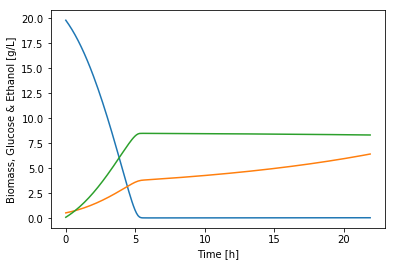

In [9]:
plt.plot(time[0:199],Glu_path)
plt.plot(time[0:199],X_path)
plt.plot(time[0:199],Eth_path)
plt.ylabel('Biomass, Glucose & Ethanol [g/L]')
plt.xlabel('Time [h]')
plt.show()